In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re
from pyattck import Attck
import requests
from stix2 import MemoryStore, Filter

In [4]:
# Settings Values - for apriori algorithm
confidenceLevel = 0.70
supportLevel = 0.05
abstract = False
# initial actor value to build the activity attack-graph from 
intelSeed = "G0079"

In [5]:
def GenerateAprioriLists():
    # some data comes from this dataset with TTPs
    df = pd.read_csv("Categorized_Adversary_TTPs.csv") # sample dataset of attacks


    # more data is gained by using attck data from actors and malware TTPs
    attack = Attck()

    actors = {}
    for actor in attack.enterprise.actors:
        actors[actor.id] = actor
    malwares = attack.enterprise.malwares + attack.enterprise.tools
    ttpLists = []
    for malware in malwares:
        ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

    # to use the apriori we need to generate a list of lists
    aprList = ttpLists
    for row in df.values:
        aprList.append((row[13].strip('][').split(', ')))
    return aprList

In [6]:
def abstractTTPs(ttpList):
    for i in range(0,len(ttpList)):
        ttpList[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in ttpList[i]]
    return ttpList 

In [7]:
# takes a list of lists and returns a list of rules sorted by size 
def AprioriMining(aprList):
    # perform apriori rule association mining
    itemsets, rules = apriori(aprList, min_support=supportLevel, min_confidence=confidenceLevel)
    
    # sort by size to get the 1:1 mappings first and so on. 
    ruleNums = np.array([len(rule.lhs+rule.rhs) for rule in rules])
    rules = np.array(rules)
    inds = ruleNums.argsort()[::]
    rules = rules[inds]
    rules = [x for x in filter(lambda rule: len(rule.lhs+rule.rhs) <= 4, rules)]
    return rules

In [8]:
# downloads latest MITRE framework from the branch
def get_data_from_branch(domain):
    """get the ATT&CK STIX data from MITRE/CTI. Domain should be 'enterprise-attack', 'mobile-attack' or 'ics-attack'. Branch should typically be master."""
    stix_json = requests.get(f"https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/{domain}/{domain}.json").json()
    return MemoryStore(stix_data=stix_json["objects"])

src = get_data_from_branch("enterprise-attack")

In [9]:
# get TTPs from seed, where seed is an APT group code: GXXXX
def ExtractSeedTTPs(seed):
    seeds = []
    actor = actors[seed]
    for ttp in actor.techniques:
        seeds.append(ttp.id)
        
    # if we are using abstracted TTPs then remove sub technique
    if (abstract):
        for i in range(0, len(seeds)):
            seeds[i] = re.sub(r'\.[0-9]+', '', seeds[i])
    return seeds

In [ ]:
def Export_Bundle(fi):
    

In [17]:
# each rule has a confidence, lift, support, lhs, rhs, conviction, rule power factor (RPF), 

# takes an APTGroup and generates hypothesized relationships and attack pattern objects
# returns a tuple of: (displayInfo, attackPatterns, relationships, groupings)
def CreateRelationships(APTGroup, aprioriLists):
    displayInfo = [] #stores the TTP and tactic for easy logging
    seen = [] #stores TTPs that have been seen by the algorithm
    attackPatterns = [] #stores generated attack pattern objects
    relationships = {} # stores generated relationship objects
    groupings = {} # stores generated grouping objects
    
    # get seeds out of the APT group
    #seeds = ExtractSeedTTPs(APTGroup)
    seeds = ["T1566", "T1204"]
    
    # perform association rule mining
    rules = AprioriMining(aprioriLists) 
    
    #add seeds to activity-attack-graph as nodes
    for seed in seeds:
        # get the stix object for the TTP
        ttp = src.query([ Filter("external_references.external_id", "=", seed) ])[0]
        
        # create and add objects to lists, context is used to identify seeds from hypothesized events
        groupings[seed] = (Grouping(object_refs=[ttp.id], context = "Seed Event"))
        attackPatterns.append(src.query([ Filter("external_references.external_id", "=", seed) ])[0])
    
    seedTotals = ["'"+x+"'" for x in seeds]
    # use a queue to iterate through and create a tree of TTPs
    while len(seeds) > 0:
        for rule in rules:
            # check to see if the left hand side of a rule is satisfied 
            if "'"+seeds[0]+"'" in rule.lhs and set(rule.lhs).issubset(seedTotals):
                #if the lhs is satisfied, then loop through each TTP in the rhs 
                for ttpName in rule.rhs:
                    # if this TTP hasn't been visited already then create STIX objects
                    if ttpName not in seen:
                        ttp = src.query([ Filter("external_references.external_id", "=", ttpName[1:-1]) ])[0]
                        
                        # track rule tactics for logging to displayInfo
                        tactics = []
                        for i in ttp['kill_chain_phases']:
                            tactics.append(i['phase_name'])
                        
                        # create a new grouping object with the rule name. 
                        # I am using ttpName[1:-1] here because TTPs have quotes around them for some reason 
                        # so I want to get rid of the quotes
                        # later I will fix this issue so that ttpName[1:-1] is not neccessary
                        groupings[ttpName[1:-1]] = (Grouping(object_refs=[ttp.id], context = "Hypothesized Event"))
                        
                        displayInfo.append([ttp['name'], ttpName[1:-1], tactics])
                        attackPatterns.append(ttp)
                        seedTotals.append(ttpName)
                        seen.append(ttpName)
                        seeds.append(ttp['external_references'][0]['external_id'])

                    # if the relationship already exists between two objects then we take the one with higher confidence
                    # make sure the exact relationship does not alraedy exist
                    if not (groupings[seeds[0]]['id'], groupings[ttpName[1:-1]]['id']) in relationships:
                        # if the opposite relationship exists then choose the one with the highest confidence to add
                        # we do this because if we do not then on the graph there will be two arrows going opposite directions to connect the same 2 TTPs
                        # this causes clutter and makes the confidence values unreadable since they will be layered on top of each other
                        if (groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id']) in relationships:
                            # if existing relationship has higher confidence, move on
                            if float(relationships[(groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id'])]['relationship_type']) > rule.confidence:
                                continue # move to next iteration of for loop, so code after this statement won't execute
                            # if existing relationship has lower confidence, delete it and let the new relationship take it's place
                            else:
                                del relationships[(groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id'])]
                        relationships[(groupings[seeds[0]]['id'], groupings[ttpName[1:-1]]['id'])] = Relationship(groupings[seeds[0]]['id'], str(round(rule.confidence, 3)), groupings[ttpName[1:-1]]['id'])
        
        # pop to progress the queue
        seeds.pop(0)

    return (displayInfo, attackPatterns, relationships, groupings)

In [11]:
aprioriList = abstractTTPs(GenerateAprioriLists()) # generate lists for apriori
#aprioriList = (GenerateAprioriLists())

In [18]:
displayInfo, attackPatterns, relationships, groupings = CreateRelationships(intelSeed, aprioriList)

In [13]:
# displays the results of the algorithm 
for info in displayInfo:
    print(f"{info[1]}:\t{info[0]}\t {info[2]}")
    print("")

T1059:	Command and Scripting Interpreter	 ['execution']

T1105:	Ingress Tool Transfer	 ['command-and-control']

T1204:	User Execution	 ['execution']

T1027:	Obfuscated Files or Information	 ['defense-evasion']

T1071:	Application Layer Protocol	 ['command-and-control']

T1082:	System Information Discovery	 ['discovery']

T1547:	Boot or Logon Autostart Execution	 ['persistence', 'privilege-escalation']

T1566:	Phishing	 ['initial-access']

T1140:	Deobfuscate/Decode Files or Information	 ['defense-evasion']

T1057:	Process Discovery	 ['discovery']

T1083:	File and Directory Discovery	 ['discovery']

T1070:	Indicator Removal	 ['defense-evasion']



In [14]:
# bundle up stix objects
bundle = Bundle(attackPatterns+list(groupings.values())+list(relationships.values()), allow_custom=True)

In [19]:
# export stix objects for visualization here: https://github.com/yukh1402/cti-stix-diamond-activity-attack-graph
with open("test.json", "w") as f:
    f.write(bundle.serialize())
    f.close()

In [19]:
# need to create relationshiops
# for some reason APOs are off center under tactics 

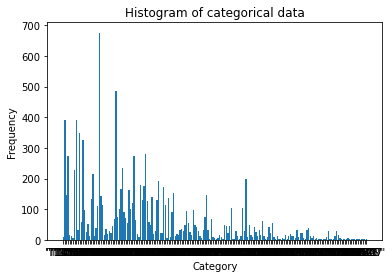

In [89]:
import matplotlib.pyplot as plt
from collections import Counter

def calculate_support(lists):
    value_counts = {}
    total_values = 0
    for lst in lists:
        for value in lst:
            value_counts[value] = value_counts.get(value, 0) + 1
            total_values += 1
    return {value: count / total_values for value, count in value_counts.items()}


support = calculate_support(aprList)

data = aprList

# Flatten the list of lists
flattened_data = [item for sublist in data for item in sublist]

# Count the occurrences of each category
histogram = Counter(flattened_data)

plt.bar(histogram.keys(), histogram.values())
plt.title("Histogram of categorical data")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()


In [12]:
ttps = GenerateAprioriLists()

In [13]:
attps = abstractTTPs(ttps)